In [11]:
from rembg import remove
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torchvision import models, transforms
from LPIPS import LPIPS
from ImageProcessor import ImageProcessor
from NST import NST
import warnings
import time
warnings.filterwarnings("ignore")

In [18]:
#Code based on https://docs.pytorch.org/tutorials/advanced/neural_style_tutorial.html
        
class GatsyModel(NST):
    def __init__(self, content_path, style_paths, prebuild_encoder = None, prebuild_decoder = None):
        super().__init__(content_path, style_paths, prebuild_encoder, prebuild_decoder)
        self.norm_mean = torch.tensor([0.485, 0.456, 0.406]).view(1,3,1,1)
        self.norm_std  = torch.tensor([0.229, 0.224, 0.225]).view(1,3,1,1)
        self.content_layers = ['conv_4']
        self.style_layers = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']


    class Normalization(nn.Module):
        def __init__(self, mean, std):
            super().__init__()
            self.mean = mean.clone().detach()
            self.std = std.clone().detach()
    
        def forward(self, img):
            return (img - self.mean) / self.std

    class ContentLoss(nn.Module):
        def __init__(self, target):
            super().__init__()
            self.target = target.detach()
            self.loss = torch.tensor(0.0)
    
        def forward(self, input):
            self.loss = nn.functional.mse_loss(input, self.target)
            return input
        
    class StyleLoss(nn.Module):
        def __init__(self, target_feature):
            super().__init__()
            self.target = GatsyModel.gramMatrix(target_feature).detach()
            self.loss = torch.tensor(0.0)
    
        def forward(self, input):
            G = GatsyModel.gramMatrix(input)
            self.loss = nn.functional.mse_loss(G, self.target)
            return input
            
    @staticmethod
    def gramMatrix(input):
        a, b, c, d = input.size()  # a=batch size(=1)
        features = input.view(a * b, c * d) 
        G = torch.mm(features, features.t())  

        return G.div(a * b * c * d)

    def get_style_model_and_losses(self, cnn, style_img, content_img):
        normalization = self.Normalization(self.norm_mean, self.norm_std)
    
        content_losses = []
        style_losses = []
    
        model = nn.Sequential(normalization)
    
        i = 0  
        for layer in cnn.children():
            if isinstance(layer, nn.Conv2d):
                i += 1
                name = 'conv_{}'.format(i)
            elif isinstance(layer, nn.ReLU):
                name = 'relu_{}'.format(i)
                layer = nn.ReLU(inplace=False)
            elif isinstance(layer, nn.MaxPool2d):
                name = 'pool_{}'.format(i)
            elif isinstance(layer, nn.BatchNorm2d):
                name = 'bn_{}'.format(i)
            else:
                raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))
    
            model.add_module(name, layer)
    
            if name in self.content_layers:
                target = model(content_img).detach()
                content_loss = self.ContentLoss(target)
                model.add_module("content_loss_{}".format(i), content_loss)
                content_losses.append(content_loss)
    
            if name in self.style_layers:
                target_feature = model(style_img).detach()
                style_loss = self.StyleLoss(target_feature)
                model.add_module("style_loss_{}".format(i), style_loss)
                style_losses.append(style_loss)
    
        for i in range(len(model) - 1, -1, -1):
            if isinstance(model[i], self.ContentLoss) or isinstance(model[i], self.StyleLoss):
                break
    
        model = model[:(i + 1)]
    
        return model, style_losses, content_losses

    def run_style_transfer(self, cnn, content_img, style_img, num_steps=300, style_weight=1000000, content_weight=1):
        print('Building the style transfer model..')
        model, style_losses, content_losses = self.get_style_model_and_losses(cnn, style_img, content_img)

        input_img = content_img.clone().requires_grad_(True)    
        optimizer = torch.optim.LBFGS([input_img])
    
        print('Optimizing..')
        run = [0]
        while run[0] <= num_steps:
    
            def closure():
                with torch.no_grad():
                    input_img.clamp_(0, 1)
    
                optimizer.zero_grad()
                model(input_img)
                style_score = 0
                content_score = 0
    
                for sl in style_losses:
                    style_score += sl.loss
                for cl in content_losses:
                    content_score += cl.loss
    
                style_score *= style_weight
                content_score *= content_weight
    
                loss = style_score + content_score
                loss.backward()
    
                run[0] += 1
    
                return loss
    
            optimizer.step(closure)
    
        return input_img.detach().clamp(0, 1)

    def pipeline(self):
        styleImage = self.styles[0].tensorisedImage(1)
        contentImage = self.content.tensorisedImage(1)

        self.start = time.perf_counter()
        output = self.run_style_transfer(self.encoder,contentImage,styleImage)
        self.end = time.perf_counter()

        self.stylisedTensor = output.detach().clamp(0, 1)
        self.stylisedImage = self.stylisedTensor.squeeze(0).permute(1,2,0).numpy()
        
        return self.stylisedImage

In [19]:
image_path = "content/avril.jpg"
style_path = "style/sketch.png"


encoder = models.vgg19(weights=models.VGG19_Weights.DEFAULT).features.eval()

for p in encoder.parameters():
    p.requires_grad_(False)

nstModel = GatsyModel(image_path, [style_path])
nstModel.uploadEncoder(encoder)


In [20]:
nstModel.processor()
nstModel.pipeline()

Building the style transfer model..
Optimizing..


array([[[0.18309097, 0.44984365, 0.27095398],
        [0.26006007, 0.4131526 , 0.24127325],
        [0.38926342, 0.44446456, 0.2382736 ],
        ...,
        [0.61386496, 0.6069532 , 0.38877487],
        [0.5895171 , 0.558822  , 0.40396714],
        [0.6211281 , 0.45494974, 0.2441162 ]],

       [[0.21725982, 0.29058015, 0.19033127],
        [0.24881294, 0.21050462, 0.3038935 ],
        [0.28712043, 0.24285138, 0.32154328],
        ...,
        [0.59913087, 0.6552858 , 0.6623333 ],
        [0.49482676, 0.69708014, 0.77941966],
        [0.58350617, 0.66868436, 0.61181724]],

       [[0.24418558, 0.18199146, 0.18594621],
        [0.21743354, 0.16729768, 0.31689265],
        [0.11659961, 0.2502826 , 0.25469515],
        ...,
        [0.75245816, 0.5565111 , 0.58247745],
        [0.6375153 , 0.58664674, 0.67385316],
        [0.7063992 , 0.66983175, 0.58141094]],

       ...,

       [[0.4874547 , 0.45076525, 0.11004131],
        [0.26066613, 0.32989517, 0.3750092 ],
        [0.25408953, 0

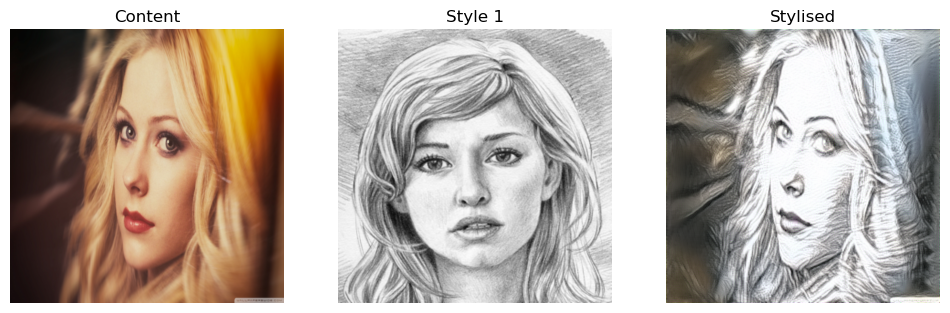

In [22]:
nstModel.displayImages()

In [23]:
nstModel.evaluate()

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /opt/anaconda3/lib/python3.11/site-packages/lpips/weights/v0.1/alex.pth


(0.718, '359400.235 ms')